## 1. Example Performance Uploads with Noises

In [25]:
import numpy as np
X = [0.47355184638423353,0.4880126114596745,0.48197951076343787,0.4910955877995803,0.49148326528871633,0.4942378553333534,0.49584690352035904,0.4998314645835072,0.5052953918607438,0.5029510307609053]
A = np.array([X,[0]*len(X)])
sigma = 1.0
personal_noise = (sigma * np.random.randn(2)).reshape((2,1))
print(personal_noise)
B = A + personal_noise
C = B + 0.3 * np.random.randn(len(A),len(A[0]))

[[-0.71952388]
 [ 0.14721603]]


In [26]:
A.shape

(2, 10)

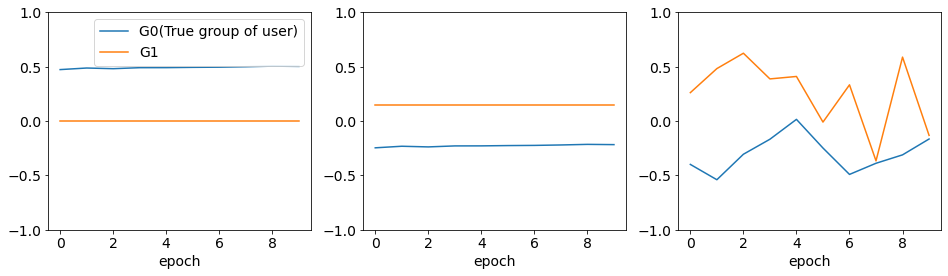

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14

plt.figure(figsize = (16, 4))
plt.subplot(1,3,1)
plt.plot(A.transpose())
plt.ylim(-1.0,1.0)
plt.xlabel('epoch')
plt.legend(['G0(True group of user)','G1'])
# plt.title('Original uploads')

plt.subplot(1,3,2)
plt.plot(B.transpose())
plt.ylim(-1.0,1.0)
plt.xlabel('epoch')
# plt.title('After adding personal noise')

plt.subplot(1,3,3)
plt.plot(C.transpose())
plt.ylim(-1.0,1.0)
plt.xlabel('epoch')
# plt.title('After adding epoch noise')
plt.show()

## 2. Group Differences during Training

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [81]:
ROOT="/home/sl1471/workspace/experiments/"
group_feature = 'activity'
best_setting = {'ml-1m': {'MF': [], 
                          'FedMF': [], 
                          'FairMF': [
                              f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.9_g{group_feature}.log'
                          ],
                          'F2MF': [
                              f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.7_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.5_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.3_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.1_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.3_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.5_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.7_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.9_sigma0_g{group_feature}.log'
#                               f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.7_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.5_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.3_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.1_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.3_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.5_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.7_sigma1.0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.9_sigma1.0_g{group_feature}.log'
                          ]
                         },
               'amz_Movies_and_TV': {'MF': [], 
                          'FedMF': [], 
                          'FairMF': [
                              f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.9_g{group_feature}.log'
                          ],
                          'F2MF': [
#                               f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.7_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.5_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.3_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.1_sigma0_g{group_feature}.log'
                              f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.1_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.3_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.5_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.7_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.9_sigma0_g{group_feature}.log'
                          ]
                         }}

In [82]:
from utils import extract_args, extract_epochwise_result
import numpy as np
groups = []
data_key = 'ml-1m'
# data_key = 'amz_Movies_and_TV'
# data_key = 'amz_Books'
training_curves = {} # {fair_lambda: {group_feature: [values]}}
D = {} # {fair_lambda: {group_feature: [values]}}
for log_name in best_setting[data_key]['F2MF']:
    log_file_path = ROOT + data_key + log_name
    args = extract_args(log_file_path)
    observation_result = extract_epochwise_result(log_file_path, 'Previous statistics:')
    if len(groups) == 0:
        groups = [G for G in observation_result[0]]
    training_curves[args.fair_lambda] = {G: np.array([epoch_result[G] for epoch_result in observation_result])
                                         for G in groups}
    D_log = extract_epochwise_result(log_file_path, 'D:', next_line = False)
    D[args.fair_lambda] = {G: np.array([epoch_result[G] for epoch_result in D_log])
                                         for G in groups}
# print(training_curves)

/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.7_sigma0_gactivity.log
/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.5_sigma0_gactivity.log
/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.3_sigma0_gactivity.log
/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.1_sigma0_gactivity.log
/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma0_gactivity.log
/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.3_sigma0_gactivity.log
/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.5_sigma0_gactivity.log
/home/sl1471/workspace/

In [83]:
group_differences = {} # {fair_lambda: [value]}
for lbd, group_curves in training_curves.items():
    L = len(group_curves[groups[0]])
    diff_sum,diff_count = np.zeros(L),0.
    for i,G0 in enumerate(groups):
        curve0 = group_curves[G0]
        for G1 in groups[i+1:]:
            curve1 = group_curves[G1]
            diff_sum += np.abs(curve1 - curve0)
            diff_count += 1
    group_differences[lbd] = diff_sum / diff_count
print(group_differences)

{-0.7: array([0.00000000e+00, 3.91564439e-06, 4.89939895e-04, 1.18611251e-03,
       1.89199972e-03, 2.54414392e-03, 3.24239930e-03, 3.83620352e-03,
       4.42070746e-03, 4.99156913e-03, 5.52971891e-03, 6.07279757e-03,
       6.43470427e-03, 7.12054555e-03]), -0.5: array([0.00000000e+00, 3.91564439e-06, 4.89939895e-04, 1.11811921e-03,
       1.75638852e-03, 2.33712615e-03, 2.95782907e-03, 3.49232922e-03,
       4.02535201e-03, 4.54890536e-03, 5.04363613e-03, 5.54263814e-03,
       5.86455354e-03, 6.47216049e-03, 6.80659350e-03]), -0.3: array([0.00000000e+00, 3.91564439e-06, 4.89939895e-04, 1.04877450e-03,
       1.62880428e-03, 2.15241571e-03, 2.71319029e-03, 3.20058873e-03,
       3.69262810e-03, 4.19114598e-03, 4.66237987e-03, 5.14529452e-03,
       5.45911563e-03, 6.05615303e-03, 6.39552689e-03]), -0.1: array([0.00000000e+00, 3.91564439e-06, 4.89939895e-04, 9.80317728e-04,
       1.49102106e-03, 1.95004852e-03, 2.44268472e-03, 2.86475390e-03,
       3.29506355e-03, 3.72973972e-03, 

In [84]:
# plot_stats = {f'lambda={lbd}': group_D for lbd, group_D in D.items()}
# title = 'ML1M(activity)'
# plot_stats[title] = group_differences
# print(plot_stats)

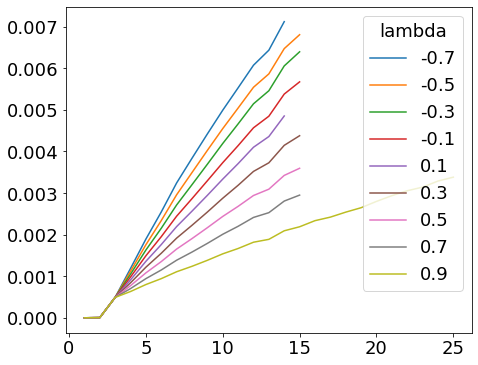

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import plot_multiple_line
plt.rcParams.update({'font.size': 18})
data_name = {"ml-1m": 'ML1M', 'amz_Movies_and_TV': 'Movies', 'amz_Books': 'Books', 'amz_Electronics': 'Electronics'}
title = f'{data_name[data_key]}({group_feature})'
plot_multiple_line({'': group_differences}, [''], ncol = 2,
                   ylabel = '', xlabel = '', legend_title = 'lambda')

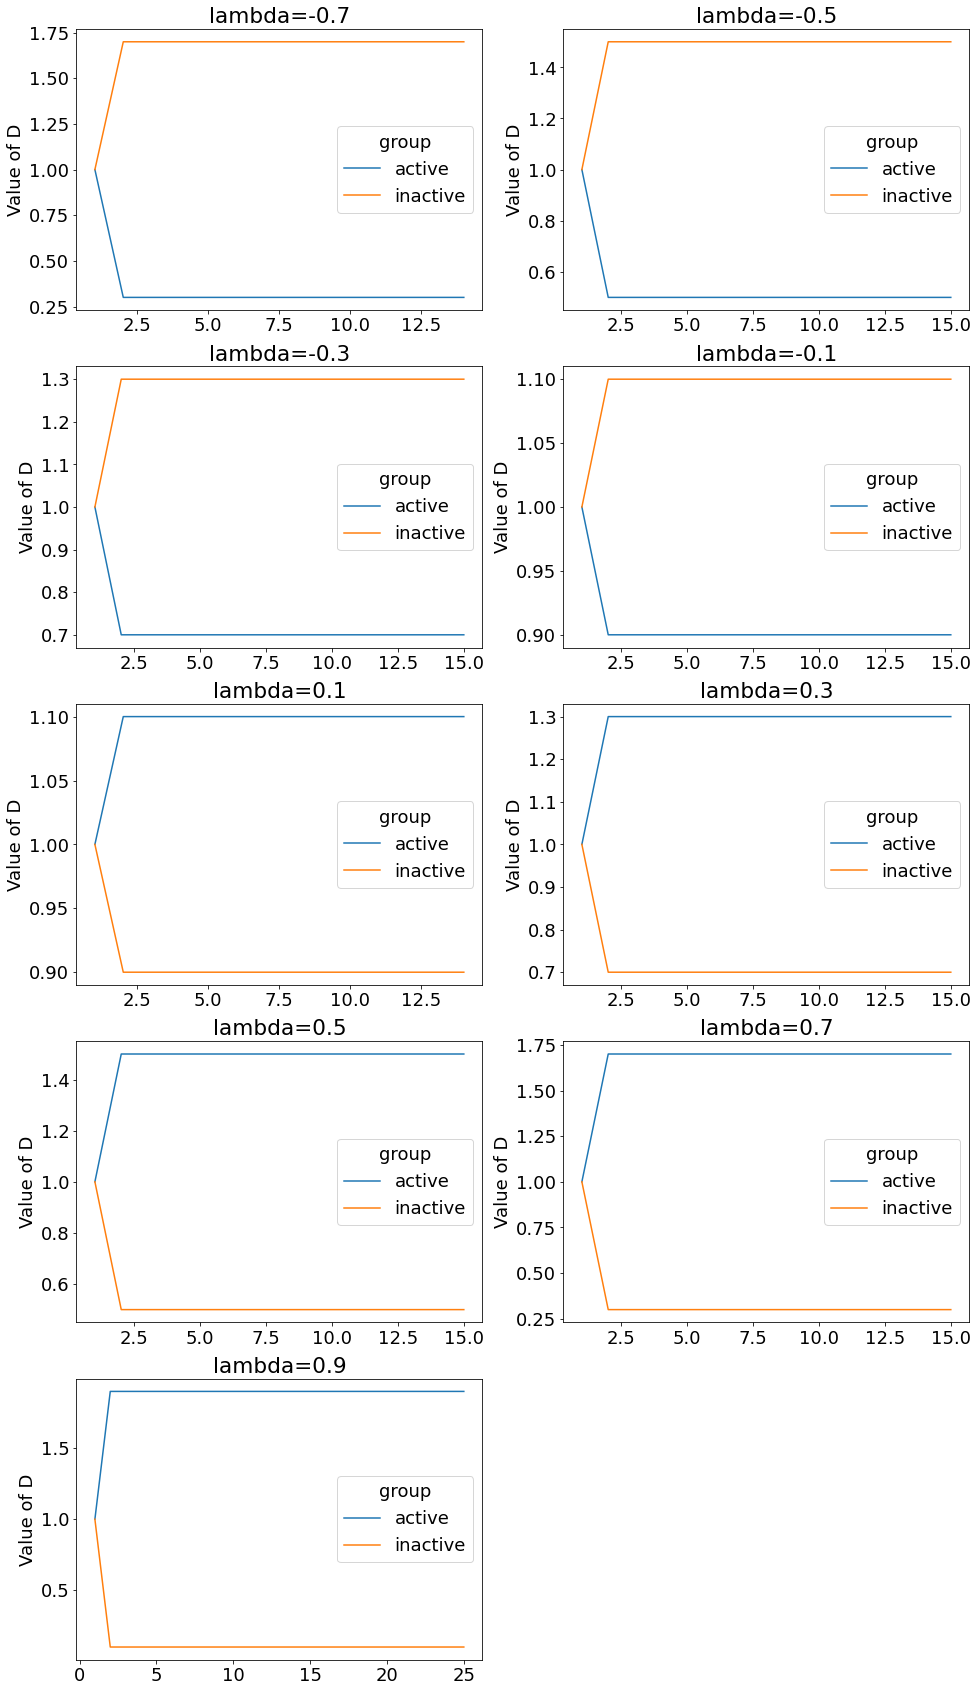

In [86]:
plt.rcParams.update({'font.size': 18})
title = 'ML1M(activity)'
plot_stats = {f'lambda={lbd}': group_D for lbd, group_D in D.items()}
plot_multiple_line(plot_stats, list(plot_stats.keys()), ncol = 2, row_height = 6,
                   ylabel = 'Value of D', xlabel = '', legend_title = 'group')